# Global Wealth Migration Intelligence System
### EDA Notebook (Clean + Fixed)
- Loads all 4 CSVs safely (works from project folder or `/mnt/data`)
- Standardizes column names and numeric types
- Fixes merge-duplicate columns (`_x/_y`) issue
- Adds overlap diagnostics + country labels on scatter plots


In [1]:
# =========================
# 0) Imports
# =========================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set_style("whitegrid")


In [2]:
# =========================
# 1) Robust data loader
# =========================
DATA_DIR_CANDIDATES = [
    Path("."),              # current working directory (your project folder)
    Path("/mnt/data")       # ChatGPT sandbox / some notebook environments
]

FILES = {
    "country_2025": "country_millionaire_migration_2025.csv",
    "growth": "fastest_growing_wealth_markets.csv",
    "yearly": "global_millionaire_migration_by_year.csv",
    "cities": "top_50_cities_centi_millionaires.csv"
}

def _find_file(filename: str) -> Path:
    for d in DATA_DIR_CANDIDATES:
        p = d / filename
        if p.exists():
            return p
    raise FileNotFoundError(
        f"Could not find {filename}. Put it in the same folder as the notebook or in /mnt/data."
    )

def load_data():
    paths = {k: _find_file(v) for k, v in FILES.items()}

    df_country_2025 = pd.read_csv(paths["country_2025"])
    df_growth = pd.read_csv(paths["growth"])
    df_yearly = pd.read_csv(paths["yearly"])
    df_cities = pd.read_csv(paths["cities"])

    # --- Clean column names (strip spaces) ---
    for df in [df_country_2025, df_growth, df_yearly, df_cities]:
        df.columns = df.columns.str.strip()

    # --- Standardize key text columns ---
    if "country" in df_country_2025.columns:
        df_country_2025["country"] = df_country_2025["country"].astype(str).str.strip()
    if "country" in df_growth.columns:
        df_growth["country"] = df_growth["country"].astype(str).str.strip()
    if "country" in df_cities.columns:
        df_cities["country"] = df_cities["country"].astype(str).str.strip()
    if "city" in df_cities.columns:
        df_cities["city"] = df_cities["city"].astype(str).str.strip()

    # --- Numeric conversions (safe) ---
    num_cols_country = [
        "net_millionaire_migration_2025",
        "estimated_migrating_wealth_usd_bn",
        "millionaire_growth_pct_2014_2024"
    ]
    for col in num_cols_country:
        if col in df_country_2025.columns:
            df_country_2025[col] = pd.to_numeric(df_country_2025[col], errors="coerce")

    num_cols_growth = [
        "millionaire_growth_pct_2014_2024",
        "millionaires_usd_1m_plus",
        "centi_millionaires_usd_100m_plus",
        "billionaires_usd_1bn_plus"
    ]
    for col in num_cols_growth:
        if col in df_growth.columns:
            df_growth[col] = pd.to_numeric(df_growth[col], errors="coerce")

    if "year" in df_yearly.columns:
        df_yearly["year"] = pd.to_numeric(df_yearly["year"], errors="coerce")
    if "migrating_millionaires" in df_yearly.columns:
        df_yearly["migrating_millionaires"] = pd.to_numeric(df_yearly["migrating_millionaires"], errors="coerce")

    if "centi_millionaires_usd_100m_plus" in df_cities.columns:
        df_cities["centi_millionaires_usd_100m_plus"] = pd.to_numeric(
            df_cities["centi_millionaires_usd_100m_plus"], errors="coerce"
        )

    # --- Convenience alias to keep the rest of the notebook clean ---
    # (Some people prefer a standard name for the migration variable.)
    if "Net_Migration" not in df_country_2025.columns and "net_millionaire_migration_2025" in df_country_2025.columns:
        df_country_2025["Net_Migration"] = df_country_2025["net_millionaire_migration_2025"]

    return df_country_2025, df_growth, df_yearly, df_cities

df_country_2025, df_growth, df_yearly, df_cities = load_data()

print("Loaded shapes:")
print("df_country_2025:", df_country_2025.shape)
print("df_growth      :", df_growth.shape)
print("df_yearly      :", df_yearly.shape)
print("df_cities      :", df_cities.shape)


Loaded shapes:
df_country_2025: (10, 5)
df_growth      : (10, 5)
df_yearly      : (14, 3)
df_cities      : (12, 3)


## 2) Quick inspection


In [3]:
display(df_country_2025.head())
display(df_growth.head())
display(df_yearly.head())
display(df_cities.head())

print("\nMissing values (country_2025):")
print(df_country_2025.isna().sum())


,country,net_millionaire_migration_2025,estimated_migrating_wealth_usd_bn,millionaire_growth_pct_2014_2024,Net_Migration
0,UAE,9800,63.0,98,9800
1,USA,7500,43.7,78,7500
2,Italy,3600,20.7,20,3600
3,Switzerland,3000,16.8,28,3000
4,Saudi Arabia,2400,18.4,55,2400


,country,millionaire_growth_pct_2014_2024,millionaires_usd_1m_plus,centi_millionaires_usd_100m_plus,billionaires_usd_1bn_plus
0,Montenegro,124,2800,22,2
1,UAE,98,130500,325,28
2,Malta,87,12200,71,5
3,Poland,82,41700,82,7
4,USA,78,6041600,10835,867


,year,migrating_millionaires,status
0,2013,51000,Normal
1,2014,57000,Normal
2,2015,64000,Normal
3,2016,82000,Normal
4,2017,95000,Normal


,city,country,centi_millionaires_usd_100m_plus
0,New York City,USA,744
1,The Bay Area,USA,675
2,Los Angeles,USA,496
3,London,UK,370
4,Beijing,China,347



Missing values (country_2025):
country                              0
net_millionaire_migration_2025       0
estimated_migrating_wealth_usd_bn    0
millionaire_growth_pct_2014_2024     0
Net_Migration                        0
dtype: int64


## 3) Global millionaire migration over time


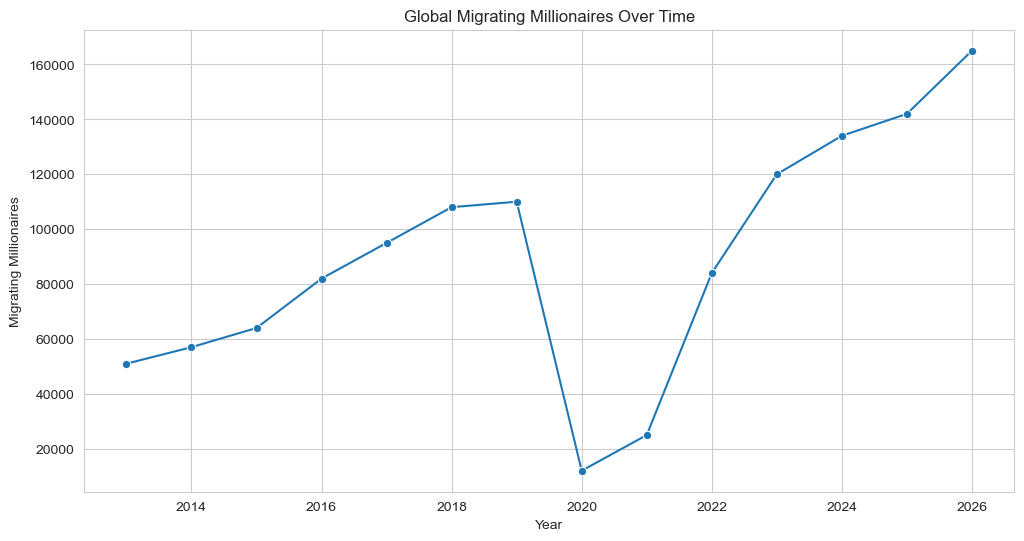

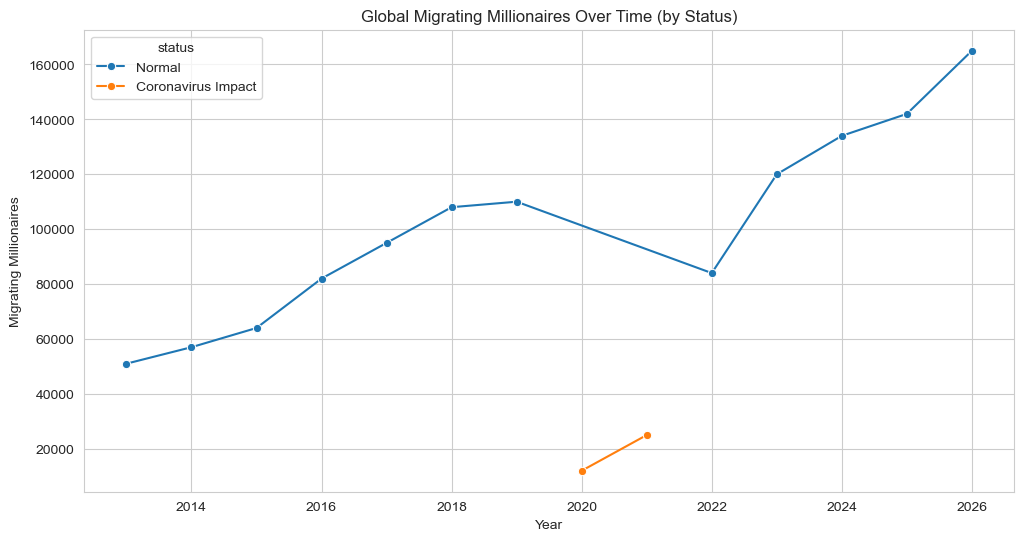

In [4]:
df_yearly_sorted = df_yearly.dropna(subset=["year"]).sort_values("year")

plt.figure(figsize=(12,6))
sns.lineplot(data=df_yearly_sorted, x="year", y="migrating_millionaires", marker="o")
plt.title("Global Migrating Millionaires Over Time")
plt.xlabel("Year")
plt.ylabel("Migrating Millionaires")
plt.show()

# If 'status' exists and has multiple categories, plot by status too
if "status" in df_yearly_sorted.columns and df_yearly_sorted["status"].nunique() > 1:
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df_yearly_sorted, x="year", y="migrating_millionaires", hue="status", marker="o")
    plt.title("Global Migrating Millionaires Over Time (by Status)")
    plt.xlabel("Year")
    plt.ylabel("Migrating Millionaires")
    plt.show()


## 4) Top gaining and losing countries (2025)


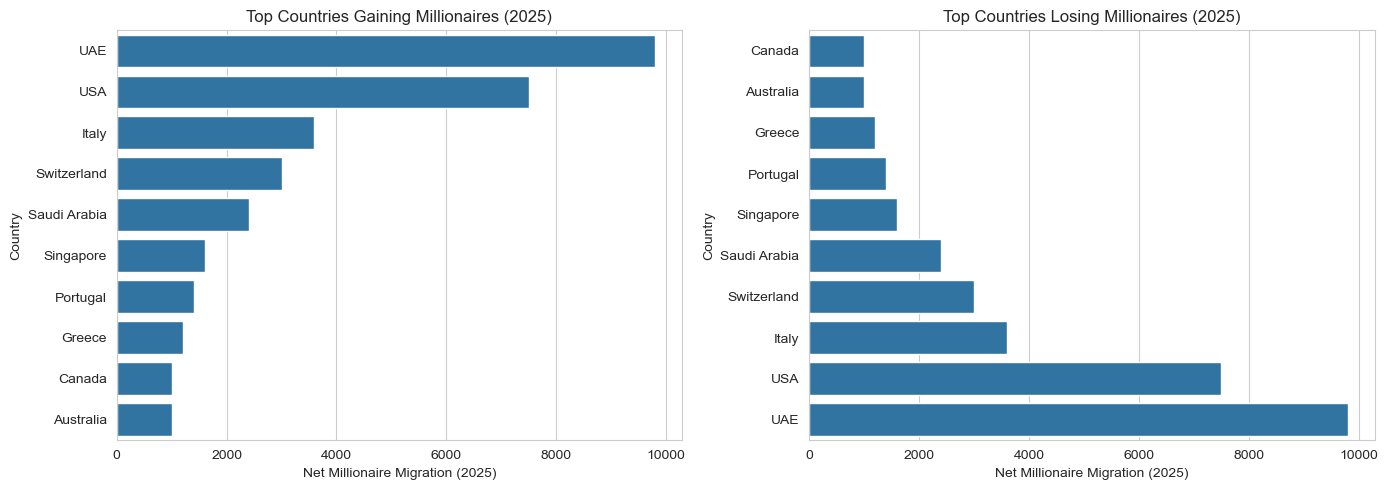

In [5]:
top_gainers = df_country_2025.sort_values("net_millionaire_migration_2025", ascending=False).head(10)
top_losers  = df_country_2025.sort_values("net_millionaire_migration_2025", ascending=True).head(10)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.barplot(data=top_gainers, x="net_millionaire_migration_2025", y="country")
plt.title("Top Countries Gaining Millionaires (2025)")
plt.xlabel("Net Millionaire Migration (2025)")
plt.ylabel("Country")

plt.subplot(1,2,2)
sns.barplot(data=top_losers, x="net_millionaire_migration_2025", y="country")
plt.title("Top Countries Losing Millionaires (2025)")
plt.xlabel("Net Millionaire Migration (2025)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()


## 5) Wealth growth vs migration (correlation study)
**Fix included:** avoids duplicate column collisions during merge and reports overlap size.


Countries in merged overlap: 2


,country,millionaire_growth_pct_2014_2024,net_millionaire_migration_2025
0,UAE,98,9800
1,USA,78,7500


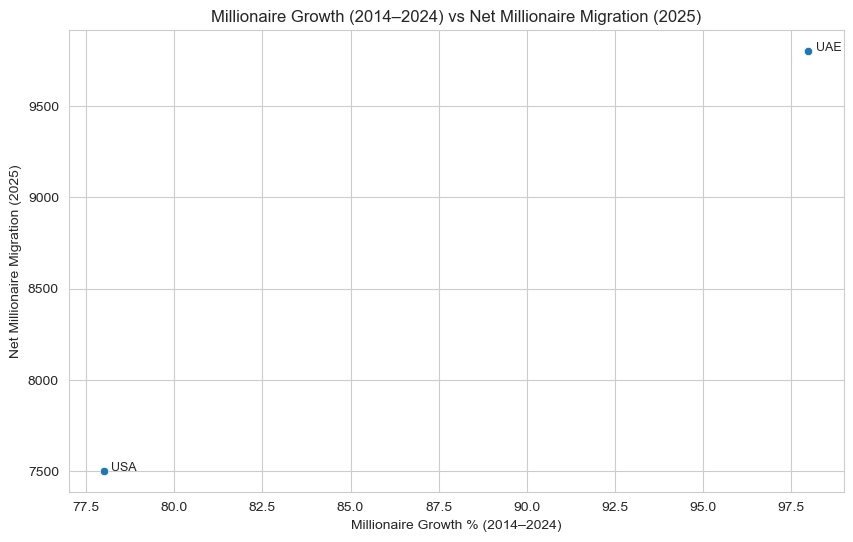

Note: overlap is small, so a trend line may be misleading. Scatter+labels is shown instead.


In [6]:
# The growth % column exists in BOTH datasets.
# If we merge without handling, pandas creates _x/_y columns and seaborn may fail.
# Strategy: keep the growth % from df_country_2025 (already in that file) and drop it from df_growth before merge.

df_growth_clean = df_growth.drop(columns=["millionaire_growth_pct_2014_2024"], errors="ignore")

merged_growth = df_country_2025.merge(df_growth_clean, on="country", how="inner")

print("Countries in merged overlap:", merged_growth["country"].nunique())
display(merged_growth[["country", "millionaire_growth_pct_2014_2024", "net_millionaire_migration_2025"]].head(20))

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=merged_growth,
    x="millionaire_growth_pct_2014_2024",
    y="net_millionaire_migration_2025"
)
# label points (helps when overlap is small)
for _, r in merged_growth.iterrows():
    if pd.notna(r["millionaire_growth_pct_2014_2024"]) and pd.notna(r["net_millionaire_migration_2025"]):
        plt.text(r["millionaire_growth_pct_2014_2024"] + 0.2, r["net_millionaire_migration_2025"], r["country"], fontsize=9)

plt.title("Millionaire Growth (2014–2024) vs Net Millionaire Migration (2025)")
plt.xlabel("Millionaire Growth % (2014–2024)")
plt.ylabel("Net Millionaire Migration (2025)")
plt.show()

# Optional: trend line (only meaningful if overlap is not tiny)
if merged_growth.shape[0] >= 8:
    plt.figure(figsize=(10,6))
    sns.regplot(
        data=merged_growth,
        x="millionaire_growth_pct_2014_2024",
        y="net_millionaire_migration_2025",
        scatter_kws={"alpha": 0.7}
    )
    plt.title("Wealth Growth vs Net Migration (with Trend Line)")
    plt.xlabel("Millionaire Growth % (2014–2024)")
    plt.ylabel("Net Millionaire Migration (2025)")
    plt.show()
else:
    print("Note: overlap is small, so a trend line may be misleading. Scatter+labels is shown instead.")


## 6) City-level wealth concentration


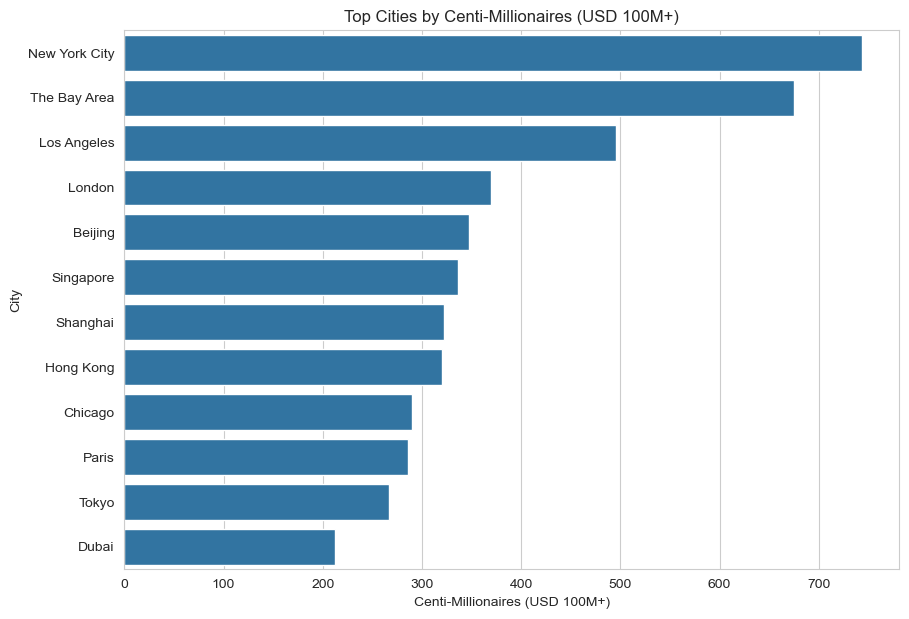

In [7]:
top_city = df_cities.sort_values("centi_millionaires_usd_100m_plus", ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(data=top_city.head(12), x="centi_millionaires_usd_100m_plus", y="city")
plt.title("Top Cities by Centi-Millionaires (USD 100M+)")
plt.xlabel("Centi-Millionaires (USD 100M+)")
plt.ylabel("City")
plt.show()


## 7) Correlation heatmap (migration + growth combined)


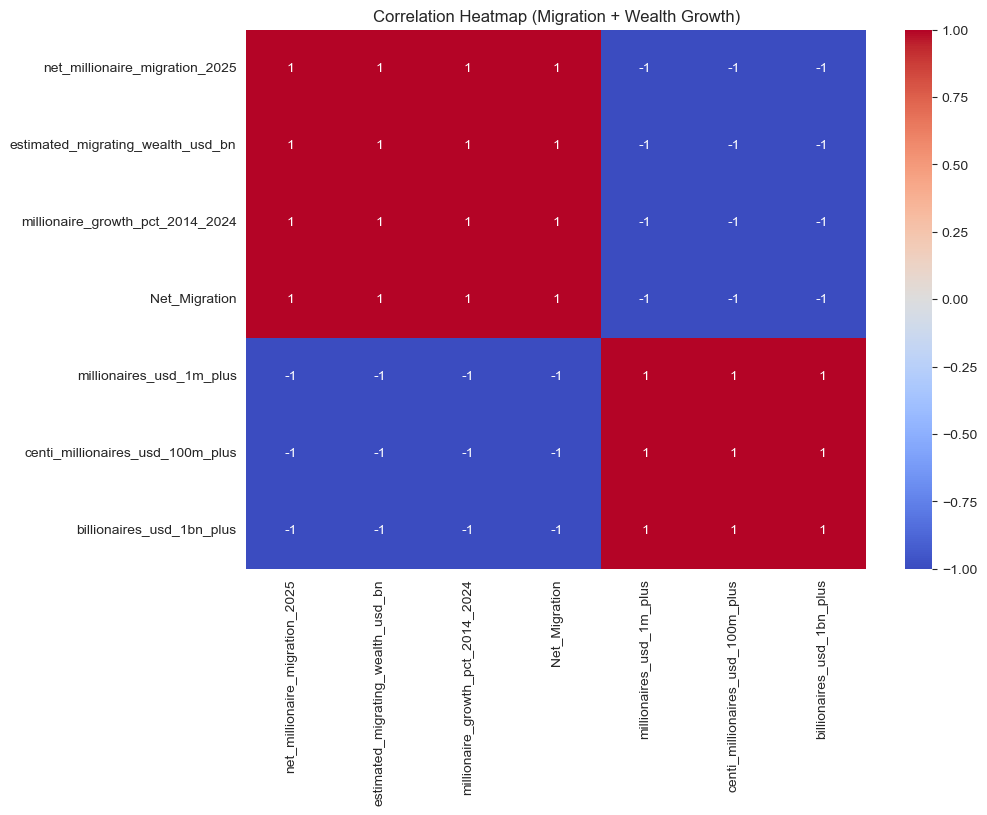

In [8]:
numeric_cols = merged_growth.select_dtypes(include=[np.number])

plt.figure(figsize=(10,7))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Migration + Wealth Growth)")
plt.show()


## 8) Ready for next step
Next: **Feature engineering** (create ML-ready features + labels for Gainer/Neutral/Loser).


# Feature Engineering + Modeling
From here we build a **model-ready dataset**, train a **Random Forest classifier**, and add **SHAP explainability**.


In [9]:
# =========================
# 9) Feature engineering (model-ready dataset)
# =========================

# Ensure data is loaded (safe if kernel restarted)
try:
    df_country_2025
    df_growth
except NameError:
    df_country_2025, df_growth, df_yearly, df_cities = load_data()

# Standardize key
df_country_2025['country'] = df_country_2025['country'].astype(str).str.strip()
df_growth['country'] = df_growth['country'].astype(str).str.strip()

# Keep only useful growth columns (avoid duplicate growth_pct column)
growth_keep = [
    'country',
    'millionaires_usd_1m_plus',
    'centi_millionaires_usd_100m_plus',
    'billionaires_usd_1bn_plus'
]
growth_available = [c for c in growth_keep if c in df_growth.columns]
df_growth_small = df_growth[growth_available].copy()

# Left-join so we keep ALL migration countries
df_model = df_country_2025.merge(df_growth_small, on='country', how='left')

# Numeric casting
for c in df_model.columns:
    if c != 'country':
        df_model[c] = pd.to_numeric(df_model[c], errors='coerce')

# Base features
df_model['abs_net_migration'] = df_model['net_millionaire_migration_2025'].abs()
df_model['wealth_per_migrant'] = df_model['estimated_migrating_wealth_usd_bn'] / (df_model['abs_net_migration'] + 1)
df_model['migration_efficiency_score'] = df_model['net_millionaire_migration_2025'] * df_model['millionaire_growth_pct_2014_2024']

# Log transforms for skewed features
df_model['log_wealth'] = np.log1p(df_model['estimated_migrating_wealth_usd_bn'])
df_model['log_abs_migration'] = np.log1p(df_model['abs_net_migration'])

# Optional: log counts if they exist
for c in ['millionaires_usd_1m_plus','centi_millionaires_usd_100m_plus','billionaires_usd_1bn_plus']:
    if c in df_model.columns:
        df_model[f'log_{c}'] = np.log1p(df_model[c])

# Fill missing values (median for numeric)
for c in df_model.select_dtypes(include=[np.number]).columns:
    df_model[c] = df_model[c].fillna(df_model[c].median())

# -------------------------
# Target label (Gainer / Neutral / Loser)
# -------------------------
def make_migration_class(series, thresh=1000):
    # If fixed threshold creates empty classes, fall back to quantiles
    y = series.copy()
    labels = pd.Series('Neutral', index=y.index)
    labels[y > thresh] = 'Gainer'
    labels[y < -thresh] = 'Loser'
    # fallback if any class too small
    vc = labels.value_counts()
    if (vc.min() < 2) or (vc.shape[0] < 3):
        q1, q2 = y.quantile(0.33), y.quantile(0.66)
        labels = pd.Series('Neutral', index=y.index)
        labels[y >= q2] = 'Gainer'
        labels[y <= q1] = 'Loser'
    return labels

df_model['migration_class'] = make_migration_class(df_model['net_millionaire_migration_2025'])

df_model[['country','net_millionaire_migration_2025','migration_class']].head()

,country,net_millionaire_migration_2025,migration_class
0,UAE,9800,Gainer
1,USA,7500,Gainer
2,Italy,3600,Gainer
3,Switzerland,3000,Gainer
4,Saudi Arabia,2400,Neutral


In [10]:
# Check class balance
df_model['migration_class'].value_counts()

migration_class
Gainer     4
Neutral    3
Loser      3
Name: count, dtype: int64

In [11]:
# =========================
# 10) Build train/test sets
# =========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Feature columns
feature_cols = [
    'millionaire_growth_pct_2014_2024',
    'log_wealth',
    'log_abs_migration',
    'wealth_per_migrant',
    'migration_efficiency_score'
]

# Add optional count features if present
for c in ['log_millionaires_usd_1m_plus','log_centi_millionaires_usd_100m_plus','log_billionaires_usd_1bn_plus']:
    if c in df_model.columns:
        feature_cols.append(c)

X = df_model[feature_cols]
y = df_model['migration_class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)

print('Classes:', list(le.classes_))
print('Train size:', X_train.shape, 'Test size:', X_test.shape)
X_train.head()

Classes: ['Gainer', 'Loser', 'Neutral']
Train size: (7, 8) Test size: (3, 8)


,millionaire_growth_pct_2014_2024,log_wealth,log_abs_migration,wealth_per_migrant,migration_efficiency_score,log_millionaires_usd_1m_plus,log_centi_millionaires_usd_100m_plus,log_billionaires_usd_1bn_plus
5,62,2.292535,7.378384,0.005559,99200,13.696658,7.538763,5.066744
1,78,3.799974,8.922792,0.005826,585000,15.614180,9.290629,6.766192
7,24,2.163323,7.090910,0.006411,28800,13.696658,7.538763,5.066744
8,26,1.902108,6.908755,0.005694,26000,13.696658,7.538763,5.066744
0,98,4.158883,9.190240,0.006428,960400,11.779136,5.786897,3.367296


## Random Forest model
Train a Random Forest classifier and evaluate with a confusion matrix, classification report, and cross-validation.

In [12]:
# =========================
# 11) Train Random Forest
# =========================
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)
print('Random Forest trained ✅')

Random Forest trained ✅


              precision    recall  f1-score   support

      Gainer       0.50      1.00      0.67         1
       Loser       1.00      1.00      1.00         1
     Neutral       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



/opt/miniconda3/envs/heart311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/heart311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/heart311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

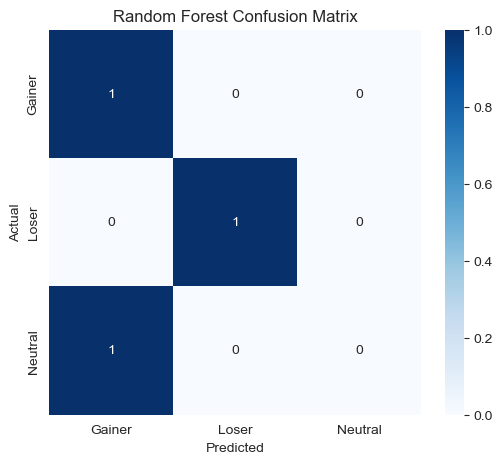

In [13]:
# =========================
# 12) Evaluation
# =========================
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

,feature,importance
2,log_abs_migration,0.326667
1,log_wealth,0.213333
0,millionaire_growth_pct_2014_2024,0.160000
4,migration_efficiency_score,0.160000
3,wealth_per_migrant,0.140000
5,log_millionaires_usd_1m_plus,0.000000
6,log_centi_millionaires_usd_100m_plus,0.000000
7,log_billionaires_usd_1bn_plus,0.000000


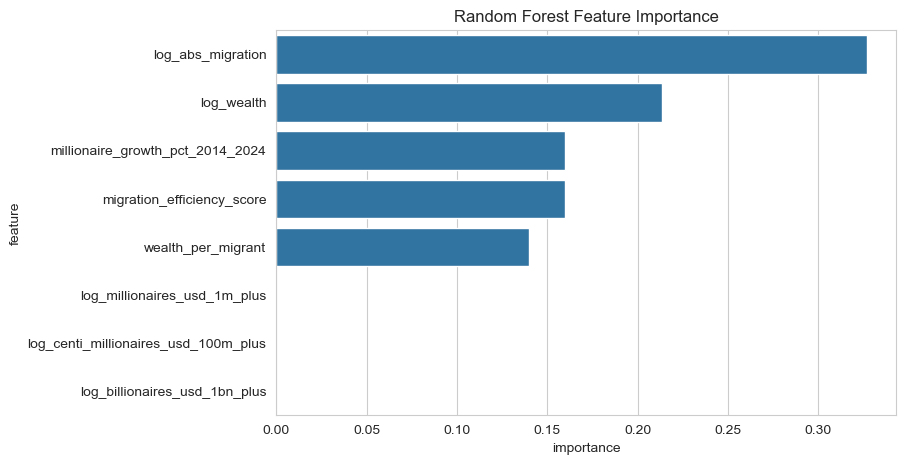

In [14]:
# Feature importance
import pandas as pd

fi = pd.DataFrame({'feature': feature_cols, 'importance': rf_model.feature_importances_})
fi = fi.sort_values('importance', ascending=False)
display(fi)

plt.figure(figsize=(8,5))
sns.barplot(data=fi, x='importance', y='feature')
plt.title('Random Forest Feature Importance')
plt.show()

In [15]:
# Cross-validation (F1 weighted) — safe for small/imbalanced datasets
from sklearn.model_selection import cross_val_score
import numpy as np

# Check class distribution
unique, counts = np.unique(y_encoded, return_counts=True)
print("Class distribution:", dict(zip(le.classes_, counts)))

# Use a safe number of folds (cannot exceed the smallest class count)
cv_folds = int(min(3, counts.min()))
if cv_folds < 2:
    print("Not enough samples per class for cross-validation (need at least 2). Skipping CV.")
else:
    cv_scores = cross_val_score(
        rf_model,
        X,
        y_encoded,
        cv=cv_folds,
        scoring="f1_weighted"
    )

    print(f"Cross-validation folds used: {cv_folds}")
    print("CV F1 weighted:", cv_scores)
    print("Mean CV F1 weighted:", cv_scores.mean())


Class distribution: {'Gainer': np.int64(4), 'Loser': np.int64(3), 'Neutral': np.int64(3)}
Cross-validation folds used: 3
CV F1 weighted: [0.65       1.         0.55555556]
Mean CV F1 weighted: 0.735185185185185


## SHAP explainability
This section adds **global** and **class-specific** explanations. It also includes a fix for the multiclass Random Forest
shape-mismatch issue (extra bias/offset column).

Number of classes: 3
X_test shape: (3, 8)


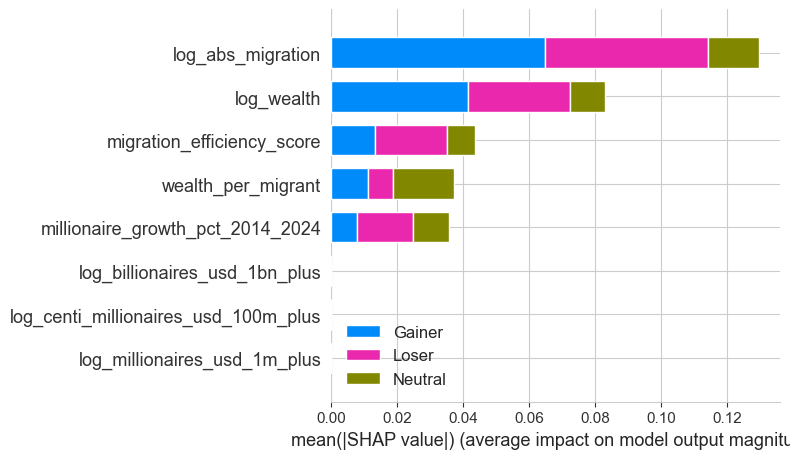

SHAP shape for Gainer: (8, 3)
Aligned X shape: (3, 3)


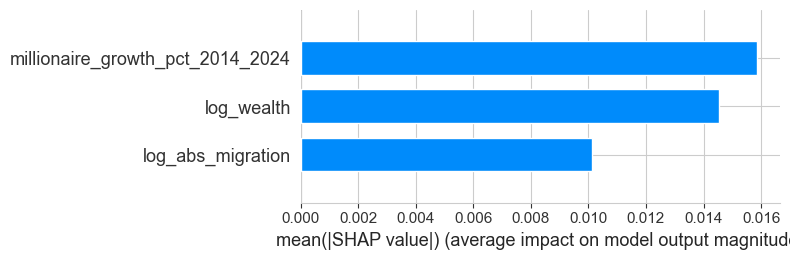

In [18]:
# SHAP explainability (stable + multiclass-safe)
# If SHAP is not installed, uncomment and run once:
# !pip install shap

import shap
import numpy as np
import matplotlib.pyplot as plt

# 1) Create SHAP explainer and compute SHAP values (safe after restart)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

print("Number of classes:", len(shap_values))
print("X_test shape:", X_test.shape)

# 2) Global importance (all classes) — always safe
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    class_names=le.classes_
)

# 3) Class-specific plots (example: Gainer)
class_name = "Gainer"
class_index = list(le.classes_).index(class_name)

sv_class = shap_values[class_index]

# TreeExplainer for multiclass can include an extra bias/offset column — drop it if present
if sv_class.shape[1] == X_test.shape[1] + 1:
    sv_class = sv_class[:, :-1]

# Some SHAP versions may return a matrix with fewer columns than X_test (small data edge-case).
# Align X_test to exactly match the SHAP matrix shape.
X_aligned = X_test.iloc[:, :sv_class.shape[1]].copy()

print(f"SHAP shape for {class_name}:", sv_class.shape)
print("Aligned X shape:", X_aligned.shape)

# Bar + dot summary for the chosen class
shap.summary_plot(sv_class, X_aligned, plot_type="bar")

# 4) Local explanation for one sample (force plot)
i = 0

expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[class_index]

